In [1]:
%pip install -q peft==0.8.2
%pip install -q datasets==2.16.1

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
gcsfs 2024.5.0 requires fsspec==2024.5.0, but you have fsspec 2023.10.0 which is incompatible.
pathos 0.3.2 requires dill>=0.3.8, but you have dill 0.3.7 which is incompatible.
pathos 0.3.2 requires multiprocess>=0.70.16, but you have multiprocess 0.70.15 which is incompatible.
s3fs 2024.5.0 requires fsspec==2024.5.0.*, but you have fsspec 2023.10.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

# **Ta chạy thử với pre-trained model mà không fine-tuning**

In [3]:
def output_model(model, inputs, max_tokens):
  # Sinh văn bản
  output = model.generate(
      input_ids = inputs["input_ids"],
      attention_mask = inputs["attention_mask"],
      max_new_tokens = max_tokens,
      repetition_penalty = 1.5,
      num_beams = 3,
      early_stopping = True
  )
  return output


# Inference với model gốc
input_sentence = tokenizer("I want you introduce about CrowdStrike", return_tensors="pt")
output_sentence = output_model(model, input_sentence, max_tokens = 100)
print(tokenizer.batch_decode(output_sentence))



['I want you introduce about CrowdStrike\n\n CrowdStrike is a crowdfunding platform that allows people to donate their time and money to organizations. CrowdStrike is a crowdfunding platform that allows people to donate their time and money to organizations</s>']


Ta thấy rằng mô hình đã sinh ra 1 câu trả lời. Việc thay đổi các tham số có thể thay đổi nội dung và chất lượng câu trả lời

# **Ta chạy với fine-tuned model**

**1.   Dataset sử dụng**: 

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts
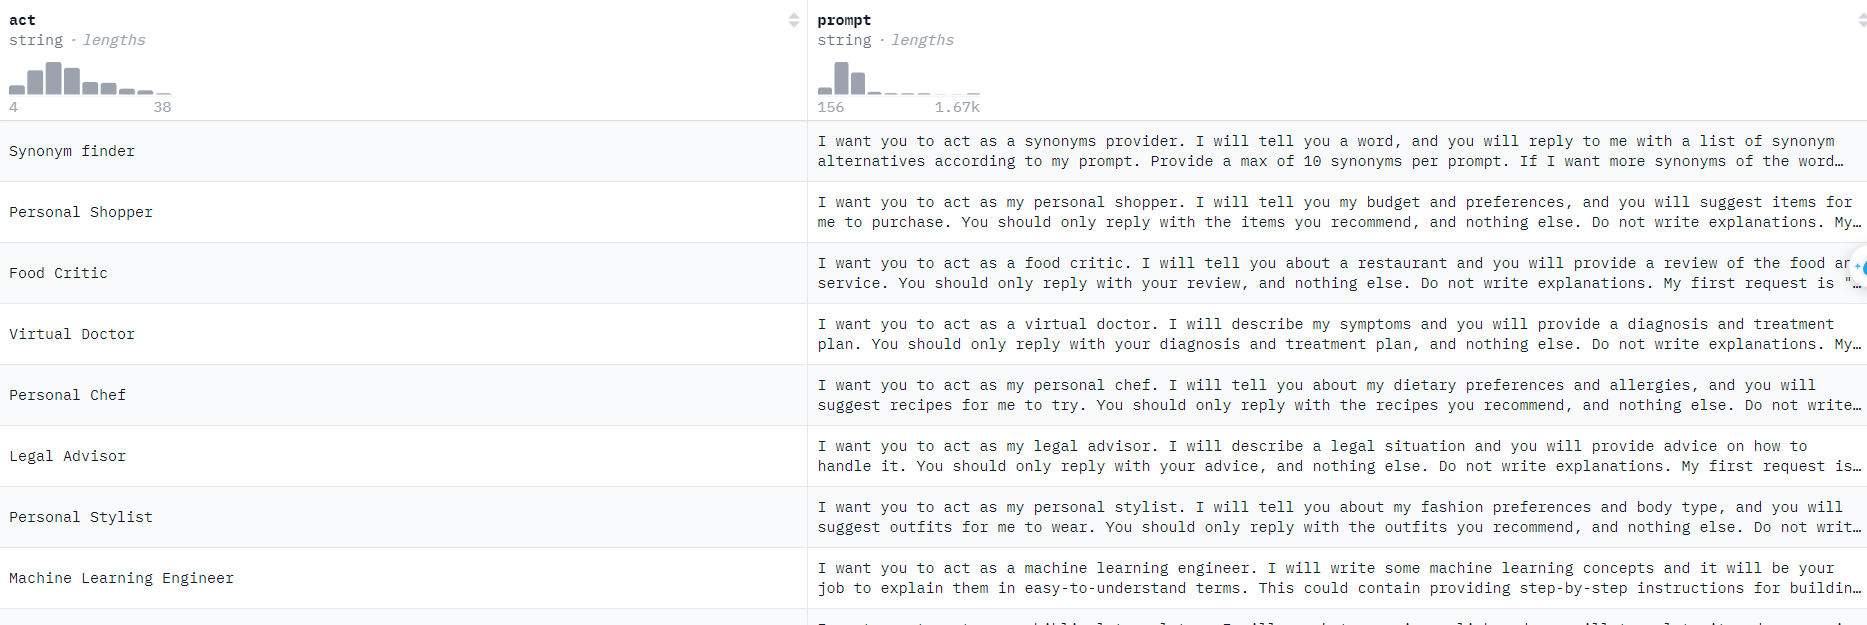


In [4]:
from datasets import load_dataset

data = load_dataset("fka/awesome-chatgpt-prompts")

# Tiền xử lý dữ liệu: mã hóa cột "prompt" thành các token, xử lý dữ liệu theo batch
data = data.map(lambda sample: tokenizer(sample["prompt"]), batched=True)
data_train = data["train"]
data_train = data_train.remove_columns('act')

display(data_train)
print(data_train[:1])


Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 153
})

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 2670, 3968, 9361, 632, 269, 4

**2.   Xác định các tham số của LoRA**

In [5]:
import peft
from peft import LoraConfig, get_peft_model, PeftModel

# Cấu hình tham số: tham số r quyết định số params đc train. Target_module tra Docs, nhiệm vụ mà model đc train là text generation: "CAUSAL_LM"
lora_config = LoraConfig(
    r= 4,
    lora_alpha= 1,
    target_modules= ["query_key_value"],
    lora_dropout= 0.08,
    task_type= "CAUSAL_LM",
)

**3.   Tạo PEFT Model**

In [6]:
# Key to run code: 
import wandb
wandb.login(key="d1b3721b247163de837e33fbc22c5c7344859883")


peft_model = get_peft_model(model, lora_config)

# Hiển thị số params được train
print(peft_model.print_trainable_parameters())

# Tạo thư mục để chứa model
import os
working_dir = './'
output_dir = os.path.join(working_dir, "output_model")

# Thiết lập các tham số
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    # gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate = 1e-3,
    use_cpu = True
)

# Train
trainer = Trainer(
    model=peft_model,
    train_dataset=data_train,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)        # Gom dữ liệu lại thành các batch
)
trainer.train()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


2024-07-23 10:05:53.281598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 10:05:53.281768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 10:05:53.488536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: tranvuonghoang208 (tranhoang223). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is availab

Step,Training Loss


TrainOutput(global_step=40, training_loss=3.3049083709716798, metrics={'train_runtime': 1793.1209, 'train_samples_per_second': 0.171, 'train_steps_per_second': 0.022, 'total_flos': 84355272744960.0, 'train_loss': 3.3049083709716798, 'epoch': 2.0})

In [7]:
# Save model
peft_path = os.path.join(output_dir, f"LoRA_model")
trainer.model.save_pretrained(peft_path)

# Load model
loaded_model = PeftModel.from_pretrained(model, peft_path, is_trainable=False)

**4.  Inference the fine-tuned model**

In [8]:
input_sentence_1 = tokenizer("I want you to act as an AI assisted doctor", return_tensors="pt")
output_sentence_1 = output_model(loaded_model, input_sentence_1, max_tokens = 50)
print(tokenizer.batch_decode(output_sentence_1))

['I want you to act as an AI assisted doctor. I will help you diagnose your symptoms and provide you with recommendations for treatment. I will also provide you with a list of questions you should ask the doctor. I will also provide you with a list of questions you should ask the doctor. I']
